Dependencies

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Lambda
from sklearn.model_selection import train_test_split

Load Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ULTRAMAX RON 92/DATA/dataset_encoded.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1919 non-null   object 
 1   Inflasi YoY    1919 non-null   float64
 2   Temp Avg       1919 non-null   float64
 3   Humidity Avg   1919 non-null   int64  
 4   RR             1919 non-null   float64
 5   Produksi BM    1919 non-null   float64
 6   Produksi BP    1919 non-null   float64
 7   Produksi CR    1919 non-null   float64
 8   Bawang Merah   1919 non-null   float64
 9   Bawang Putih   1919 non-null   float64
 10  Cabai Rawit    1919 non-null   float64
 11  is_tahun_baru  1919 non-null   int64  
 12  is_idul_fitri  1919 non-null   int64  
 13  is_natal       1919 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 210.0+ KB


Set 'Date' as Index

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_values('Date').reset_index(drop=True)

Define 'Target Cols' and 'Feature Cols'

In [4]:
target_cols = ['Bawang Merah', 'Bawang Putih', 'Cabai Rawit']
feature_cols = [col for col in df.columns if col not in target_cols + ['Date']]

Normalization and Scaling

In [6]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_cols])

Sequence Preparation

In [7]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

Splitting Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

Build and train Model

In [13]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention = Attention()([lstm_out, lstm_out])
context = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention)
output = Dense(3)(context)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 30, 64)    │     19,200 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 30, 64)    │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,395 (75.76 KB)

 Trainable params: 19,395 (75.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0460 - val_loss: 0.0687
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0286 - val_loss: 0.0498
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0255 - val_loss: 0.0350
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0216 - val_loss: 0.0429
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0215 - val_loss: 0.0491
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0206 - val_loss: 0.0562
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0180 - val_loss: 0.0534
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0164 - val_loss: 0.0596
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0162 - val_loss: 0.0592
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0152 - val_loss: 0.0560
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0149 - val_loss: 0.0527
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

Evaluation

In [15]:
y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_seq)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_true, y_pred)
print(f"MAPE: {mape_value:.2f}%")

# R² Score
r2 = r2_score(y_true, y_pred)
print(f"R-squared: {r2:.3f}")

MAE: 4824.58
RMSE: 9301.33
MAPE: 9.62%
R-squared: 0.657


Visualization

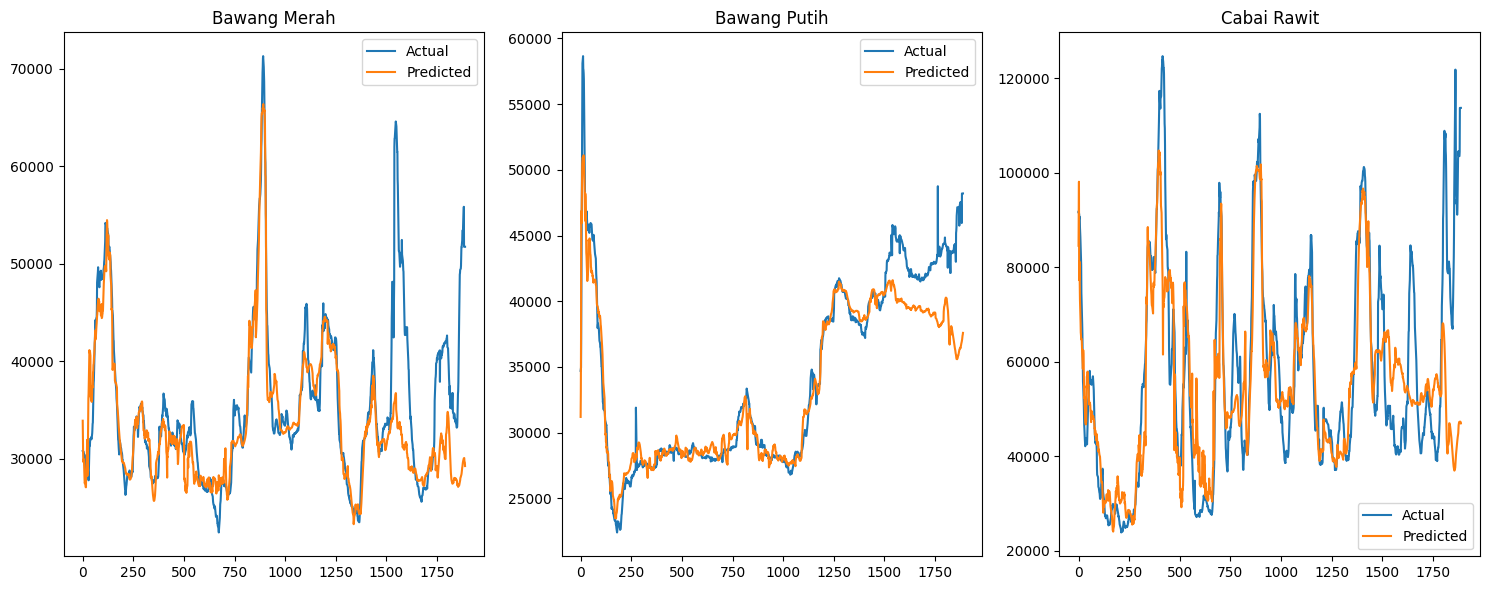

In [18]:
plt.figure(figsize=(15, 6))
for i, name in enumerate(target_cols):
    plt.subplot(1, 3, i+1)
    plt.plot(y_true[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(name)
    plt.legend()
plt.tight_layout()
plt.show()